### Introduction
Self-organizing maps is a type of ANN, an unsupervised learning technique, the neurals in SOMs are represented in a 2D map, where each cell is a $p$ dimension. The algorithm modify the location of each cell in $p$ dimension space to the location where the data is heavily concentrated there.

![Self Organizing Maps](images/self-organizing-map.png)

### Definitions
The training process of SOM is quite simple, it uses __delta rule__ to adjust the weight matrix $W$, therefore, a learning rate $\alpha$ is defined:
$$
w = w + \alpha * (x - w)
$$

Besides, the maximum radius $\phi$ to accept or reject the update at cell $i,j$ is also considered. To choose which cell to update, a best matching unit (or BMU) needed to determine, a cell is called BMU when it has shortest distance to random sample $x$.

To prevent SOM from overshoot the minimum point, the $\alpha$ and $\phi$ are decayed linearly until 0: 
$$
d = 1 - (\mathrm{t} / \mathrm{T}) \\
\alpha_t = \alpha_0 * d \\
\phi_t = \phi_0 * \lceil d \rceil
$$.

Where T is the number of iterations to update $W$, $\alpha_t$ is the alpha at time step $t$ and $\phi_t$ is the radius at time step $t$. The symbol $\lceil x \rceil$ means rounding up the decay factor.

### Training

```python
for t in range(T):
    ### Can replace this with exponential decay
    decay = 1 - (t / T)
    alpha = alpha_0 * decay
    radius = radius_0 * ceil(decay)
    sample = random(X)
    winner = find_bmu(sample, W)

    for row in range(W.shape[0]):
        for col in range(W.shape[1]):
            ### It uses manhattan distance to accept or reject update
            m_distance = np.abs(row - winner[0] + row - winner[1])
            if m_distance < radius:
                ### Delta rule to update W
                W[row][col] += alpha * (sample - W[row][col])

```

### References
- https://towardsdatascience.com/understanding-self-organising-map-neural-network-with-python-code-7a77f501e985

In [16]:
import sys
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
data, target = datasets.load_iris(return_X_y=True, as_frame=True)

In [4]:
data.columns = ["x1", "x2", "x3", "x4"]

In [7]:
data["y"] = target

In [8]:
scaler = MinMaxScaler()
data[['x1', 'x2', 'x3', 'x4']] = scaler.fit_transform(data[['x1', 'x2', 'x3', 'x4']])

<Axes: xlabel='x2', ylabel='x4'>

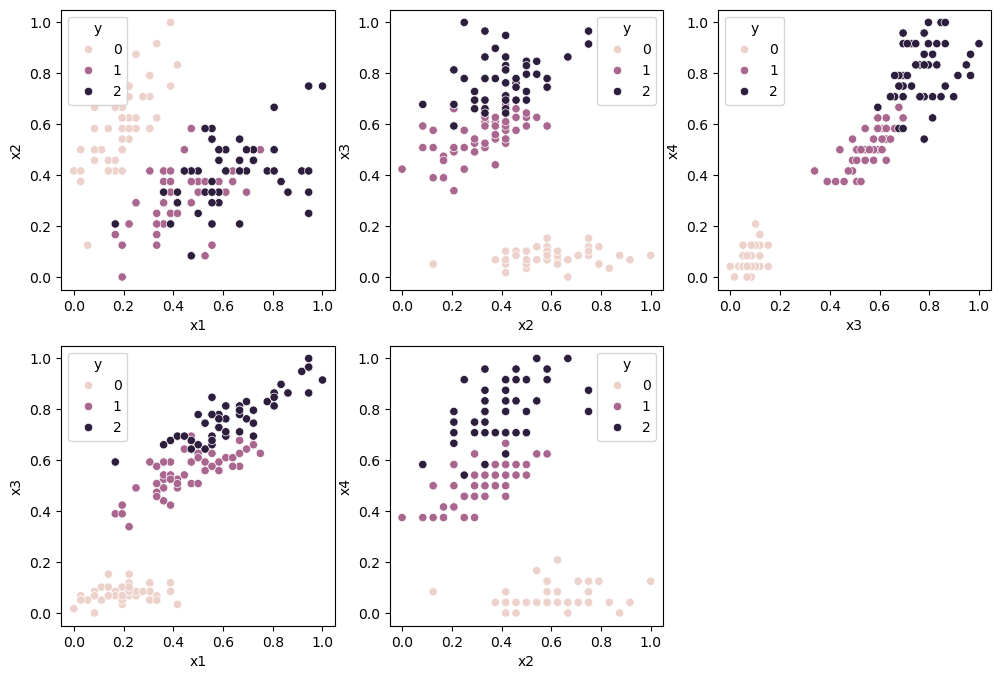

In [15]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 3, 1)
sns.scatterplot(data=data, x='x1', y='x2', hue='y')

plt.subplot(2, 3, 2)
sns.scatterplot(data=data, x='x2', y='x3', hue='y')

plt.subplot(2, 3, 3)
sns.scatterplot(data=data, x='x3', y='x4', hue='y')

plt.subplot(2, 3, 4)
sns.scatterplot(data=data, x='x1', y='x3', hue='y')

plt.subplot(2, 3, 5)
sns.scatterplot(data=data, x='x2', y='x4', hue='y')

In [17]:
train, test = train_test_split(data, test_size=0.3)

In [26]:
data_X = train[["x1", "x2", "x3", "x4"]].to_numpy()
data_y = train["y"].to_numpy()

val_X = test[["x1", "x2", "x3", "x4"]].to_numpy()
val_y = test["y"].to_numpy()

In [53]:
# hyperparameters
m = data_X.shape[0]
n = data_X.shape[1]
num_rows = 30
num_cols = 15
max_alpha = 0.5
max_radius = 4
num_steps = 10000
W = np.random.rand(num_rows, num_cols, n)

In [28]:
W.shape

(30, 30, 4)

In [29]:
data_X.shape

(105, 4)

### Train the SOM

In [75]:
def find_bmu_legacy(sample: np.ndarray, W: np.ndarray) -> np.ndarray:
    winner = [0, 0]
    sample = sample.reshape(1, -1) # make sure sample in row based format
    min_dist = sys.maxsize
    for row in range(W.shape[0]):
        for col in range(W.shape[1]):
            cur_dist = e_distance(W[row][col], sample)
            if cur_dist < min_dist:
                min_dist = cur_dist
                winner = [row, col]
    return winner

In [76]:
def find_bmu(sample: np.array, W: np.array):
    dmatrix = np.sqrt(np.sum((sample - W)**2, axis=2))
    index = np.argmin(dmatrix)
    col = index % W.shape[1]
    row = int(index / W.shape[1])
    return [row, col]

In [77]:
for sample in data_X:
    a = find_bmu_legacy(sample, W)
    b = find_bmu(sample, W)
    assert a[0] == b[0] and a[1] == b[1], f"{a} vs. {b}"

print("Test passed!")

Test passed!


In [82]:
def decay_factor(step: int, num_steps: int, max_alpha: float, max_radius: int):
    coef = 1.0 - (float(step) / num_steps)
    alpha = max_alpha * coef
    radius = np.ceil(max_radius * coef)
    return alpha, radius

In [91]:
print(f"Alpha and radius at step 0 {decay_factor(0, 10000, max_alpha, max_radius)}")
print(f"Alpha and radius at step 5000 {decay_factor(5000, 10000, max_alpha, max_radius)}")

Alpha and radius at step 0 (0.5, 4.0)
Alpha and radius at step 5000 (0.25, 2.0)


In [93]:
def update_weight(X: np.ndarray, W: np.ndarray, num_steps: int, max_alpha: float, max_radius: int):
    for step in range(num_steps):
        if (step + 1) % 1000 == 0:
            print(f"Iter {step + 1}")
            
        alpha, radius = decay_factor(step, num_steps, max_alpha, max_radius)
        sample = X[np.random.choice(X.shape[0])]
        winner = find_bmu(sample, W)

        for row in range(W.shape[0]):
            for col in range(W.shape[1]):
                m_distance = np.abs(row - winner[0] + row - winner[1])
                if m_distance < radius:
                    W[row][col] += alpha * (sample - W[row][col])

update_weight(data_X, W, num_steps, max_alpha, max_radius)

Iter 1000
Iter 2000
Iter 3000
Iter 4000
Iter 5000
Iter 6000
Iter 7000
Iter 8000
Iter 9000
Iter 10000


### Update labels for SOM

In [97]:
def assign_label(X: np.ndarray, y: np.ndarray, W: np.ndarray) -> np.ndarray:
    num_rows = W.shape[0]
    num_cols = W.shape[1]
    L = np.random.randint(y.min(), y.max() + 1, (num_rows, num_cols))
    for i in range(data_X.shape[0]):
        winner = find_bmu(data_X[i], W)
        L[winner[0]][winner[1]] = data_y[i]    
    return L

In [98]:
def make_dataframe(L: np.ndarray) -> pd.DataFrame:
    df = []
    for row in range(L.shape[0]):
        for col in range(L.shape[1]):
            df.append({'x': row, 'y': col, 'label': L[row][col]})
    return pd.DataFrame(df)

In [99]:
L = assign_label(data_X, data_y, W)

<Axes: xlabel='x', ylabel='y'>

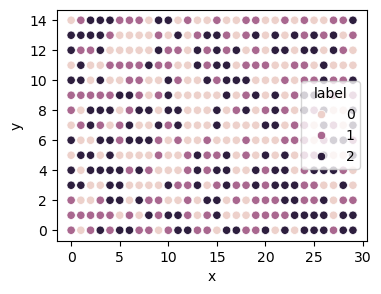

In [110]:
plt.figure(figsize=(4, 3))
sns.scatterplot(data=make_dataframe(L), x='x', y='y', hue='label')

In [104]:
def predict(W: np.ndarray, L: np.ndarray, sample: np.ndarray):
    winner = find_bmu(sample, W)
    return L[winner[0]][winner[1]]

In [105]:
accuracy = 0
for i in range(val_X.shape[0]):
    pred = predict(W, L, val_X[i])
    true = val_y[i]
    accuracy += 1 if (pred == true) else 0

print(f"Accuracy: {accuracy / val_X.shape[0]}")

Accuracy: 0.8666666666666667
